In [1]:
import numpy as np
import torch

In [2]:
arr = np.arange(100)
assert arr.base is None

In [9]:
arr_view = arr[:50]
assert arr_view.base is not None

print(arr_view.base[:4], type(arr_view.base))
print(id(arr), id(arr_view.base))

[0 1 2 3] <class 'numpy.ndarray'>
140106921126688 140106921126688


In [40]:
def info_for_two(one_array, another_array):
    """Prints side-by-side results of running np.info on its inputs."""
    def info_as_ordered_dict(array):
        """Converts return of np.infor into an ordered dict."""
        import collections
        import io
        buffer = io.StringIO()
        np.info(array, output=buffer)
        data = (
            item.split(':') for item in buffer.getvalue().strip().split('\n'))
        return collections.OrderedDict(
            ((key, value.strip()) for key, value in data))
    one_dict = info_as_ordered_dict(one_array)
    another_dict = info_as_ordered_dict(another_array)
    name_w = max(len(name) for name in one_dict.keys())
    one_w = max(len(name) for name in one_dict.values())
    another_w = max(len(name) for name in another_dict.values())
    output =  (
        f'{name:<{name_w}} : {one:>{one_w}} : {another:>{another_w}}'
        for name, one, another in zip(
            one_dict.keys(), one_dict.values(), another_dict.values()))
    print('*'*46)
    print('\n'.join(output))

In [41]:
info_for_two(arr, arr_view)
info_for_two(arr, arr[2::-2])

**********************************************
class        :        ndarray :        ndarray
shape        :         (100,) :          (50,)
strides      :           (8,) :           (8,)
itemsize     :              8 :              8
aligned      :           True :           True
contiguous   :           True :           True
fortran      :           True :           True
data pointer : 0x55bac0b32eb0 : 0x55bac0b32eb0
byteorder    :         little :         little
byteswap     :          False :          False
type         :          int64 :          int64
**********************************************
class        :        ndarray :        ndarray
shape        :         (100,) :           (2,)
strides      :           (8,) :         (-16,)
itemsize     :              8 :              8
aligned      :           True :           True
contiguous   :           True :          False
fortran      :           True :          False
data pointer : 0x55bac0b32eb0 : 0x55bac0b32ec0
byteorder    

In [91]:
window = 30
offset = 8
np.ndarray(shape = (len(arr)- window+1-offset, window-offset), dtype=arr.dtype, buffer=arr,
           offset=offset,
           strides = arr.strides*2)

array([[ 1,  2,  3, ..., 20, 21, 22],
       [ 2,  3,  4, ..., 21, 22, 23],
       [ 3,  4,  5, ..., 22, 23, 24],
       ...,
       [61, 62, 63, ..., 80, 81, 82],
       [62, 63, 64, ..., 81, 82, 83],
       [63, 64, 65, ..., 82, 83, 84]])

In [58]:
from numpy.lib.stride_tricks import as_strided

In [77]:
a = np.arange(6)
as_strided(a, shape=a.shape, strides=(16, ))

array([  0,   2,   4,  64,   0, 885])

# Variable Slices

In [152]:
import matplotlib.pyplot as plt

In [543]:
bs = 32
window_len = 64
nfeats = 5
slice_len = 45

## Numpy

In [544]:
data = np.random.randn(bs, window_len, nfeats)

In [568]:
rand_idx = np.random.randint(0, window_len-slice_len, bs)
idx_arr  = np.r_[[np.r_[idx: idx+slice_len] for idx in rand_idx]]

In [569]:
idx_flat = (idx_arr + window_len*np.arange(bs)[:, None]).flatten()
sliced = data.reshape(-1, nfeats)[idx_flat].reshape(bs, slice_len, nfeats)

print(data.reshape(-1, nfeats)[idx_flat].shape)
print(sliced.shape)

(1440, 5)
(32, 45, 5)


In [570]:
assert np.all(data ==  data.reshape(-1, nfeats).reshape(bs, window_len, nfeats))
batch = 0 

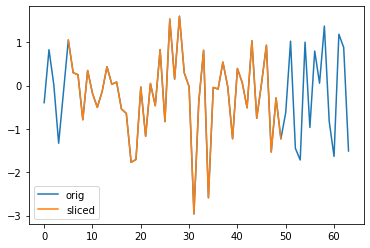

In [576]:
feat = nfeats-1
plt.plot(data[batch, : , feat], label='orig')
start_idx = idx_arr[batch][0]
padded = np.concatenate([[np.nan]*start_idx, 
                         sliced[batch, :, feat], 
                         [np.nan] * (slice_len-start_idx)])
plt.plot(padded, label='sliced')
plt.legend()

batch += 1

## PyTorch

In [617]:
dat = torch.randn(bs, window_len, nfeats)

In [662]:
rand_idx = np.random.randint(0, window_len-slice_len, bs)
idx_arr  = np.r_[[np.r_[idx: idx+slice_len] for idx in rand_idx]]
idx_flat = (idx_arr + window_len*np.arange(bs)[:, None]).flatten()
idx_flat = torch.LongTensor(idx_flat)
idx_flat.shape

torch.Size([1440])

In [663]:
assert torch.equal(dat , dat.reshape(-1, nfeats).reshape(bs, window_len, nfeats))

In [664]:
sliced = torch.index_select(dat.view(-1, nfeats), 0, idx_flat).view(bs, slice_len, nfeats)
print(sliced.shape)

torch.Size([32, 45, 5])


In [665]:
batch = 0

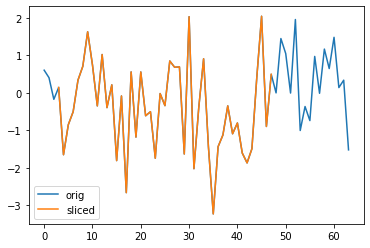

In [666]:
data = dat.numpy()
plt.plot(data[batch, : , 0], label='orig')
start_idx = idx_arr[batch][0]
padded = np.concatenate([[np.nan]*start_idx, 
                         sliced[batch, :, 0], 
                         [np.nan] * (slice_len-start_idx)])
plt.plot(padded, label='sliced')
plt.legend()
batch += 1